In [ ]:
#|default_exp benchmarking.sign_prediction_orc
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

from functools import partial

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
jax.default_device = jax.devices("cpu")

# Sign Prediction Tests - Ollivier Ricci & Foreman Ricci
> Comparisons between Diffusion Curvature and the Competition

These are the two most popular graph curvature methods. However, adapting them to point-cloud data requires a bit of care.
To make the comparison as equal as possible, we'll use the same curvature-agnostic graphformer (which is known good), then simply turn that into a networkx graph with weighted edges.

The parameters are as follows:
## Ollivier-Ricci
1. alpha - the laziness of the (single-step) diffusion.

# Machinery

We'll perform the saddle-sphere ablations in several dimensions, then merge the metrics into a single table.

In [ ]:
dims = [2, 3, 4, 5, 6]
num_pointclouds = 20

[autoreload of scipy.special._basic failed: Traceback (most recent call last):
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: comb() requires a code object with 0 free vars, not 5
]


[autoreload of scipy.integrate._quadrature failed: Traceback (most recent call last):
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: simpson() requires a code object with 0 free vars, not 5
]


[autoreload of scipy.interpolate._interpolate failed: Traceback (most recent call last):
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'interp1d' obj

[autoreload of scipy.stats._stats_py failed: Traceback (most recent call last):
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/boreas/miniforge3/envs/diffcurvs/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: kendalltau() requires a code object with 0 free vars, not 5
]


In [ ]:
SS1 = SadSpheres(
    dimension = dims, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=True,
)

Loaded evaluations on methods ['ground truth', 'Hickok & Blumberg', 'Diffusion Curvature']


In [ ]:
import networkx as nx
from GraphRicciCurvature.FormanRicci import FormanRicci

In [ ]:
from GraphRicciCurvature.OllivierRicci import OllivierRicci

In [ ]:
average_orc_across_edge(orc, 0)

0.0003336744674980602

In [ ]:
list(orc.G[0].keys())

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]

In [ ]:
from diffusion_curvature.kernels import get_curvature_agnostic_graph
def nx_graph_from_pointcloud(X):
    G = get_curvature_agnostic_graph(X)
    nx_G = nx.from_numpy_array(G.W)
    return nx_G

In [ ]:
def average_orc_across_edge(orc, idx):
    js = list(orc.G[idx].keys())
    edge_ks = [orc.G[idx][j]['ricciCurvature'] for j in js]
    return np.mean(edge_ks)
def average_frc_across_edge(orc, idx):
    js = list(orc.G[idx].keys())
    edge_ks = [orc.G[idx][j]['formanCurvature'] for j in js]
    return np.mean(edge_ks)

In [ ]:
def compute_orc_curvature_of_nodes(G, idxs = None):
    G_nx = nx.from_numpy_array(G.W)
    orc = OllivierRicci(G_nx, alpha=0.5)
    orc.compute_ricci_curvature()
    ks = []
    if idxs is None: idxs = np.arange(len(G.W))
    if isinstance(idxs, int): idxs = [idxs]
    for i in idxs:
        ks.append(
            average_orc_across_edge(orc, i)
        )
    if len(ks) == 1: return ks[0]
    return ks

def compute_frc_curvature_of_nodes(G, idxs = None):
    G_nx = nx.from_numpy_array(G.W)
    frc = FormanRicci(G_nx)
    frc.compute_ricci_curvature()
    ks = []
    if idxs is None: idxs = np.arange(len(G.W))
    if isinstance(idxs, int): idxs = [idxs]
    for i in idxs:
        ks.append(
            average_frc_across_edge(frc, i)
        )
    if len(ks) == 1: return ks[0]
    return ks

In [ ]:
#|export
from tqdm.auto import tqdm, trange
from fastcore.all import *
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
# from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *
from diffusion_curvature.kernels import *
from diffusion_curvature.kernels import tune_curvature_agnostic_kernel

method_name = "Ollivier Ricci"

def run_sadspheres(
):
    SS1 = SadSpheres(
        dimension = dims, # Dimension of saddles and spheres
        num_pointclouds = num_pointclouds, # num pointclouds to make in total
        num_points = 2000, # num points per pointclouds
        noise_level = 0, # from 0 to 1. 1 is all noise.
        include_planes=True,
    )
    known_dim_bandwidths = {}
    if method_name in SS1.imported_methods:
        return SS1
    for X in tqdm(SS1):
        dim = X.shape[1] - 1
        if dim not in known_dim_bandwidths.keys():
            kernel, ns = tune_curvature_agnostic_kernel(X, 120, tolerance = 5, max_iterations = 100, alpha = 0)
            known_dim_bandwidths[dim] = kernel
        G_simple = kernel(X)
        ks_r = compute_orc_curvature_of_nodes(G_simple, idxs = [0])
        SS1.update(ks_r, method_name = "Ollivier Ricci")

        ks_f = compute_frc_curvature_of_nodes(G_simple, idxs = [0])
        SS1.update(ks_f, method_name = "Forman Ricci")
    SS1.save_results()
    return SS1

In [ ]:
SS1 = run_sadspheres()

Loaded evaluations on methods ['ground truth', 'Hickok & Blumberg', 'Diffusion Curvature']


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
SS1.DS[0].results

{'ks': {'ground truth': -8.0,
  'Hickok & Blumberg': -3.027323619927813,
  'Diffusion Curvature': -0.9208440780639648,
  'Ollivier Ricci': 0.8035746852987119,
  'Forman Ricci': -1811.2206771486055}}

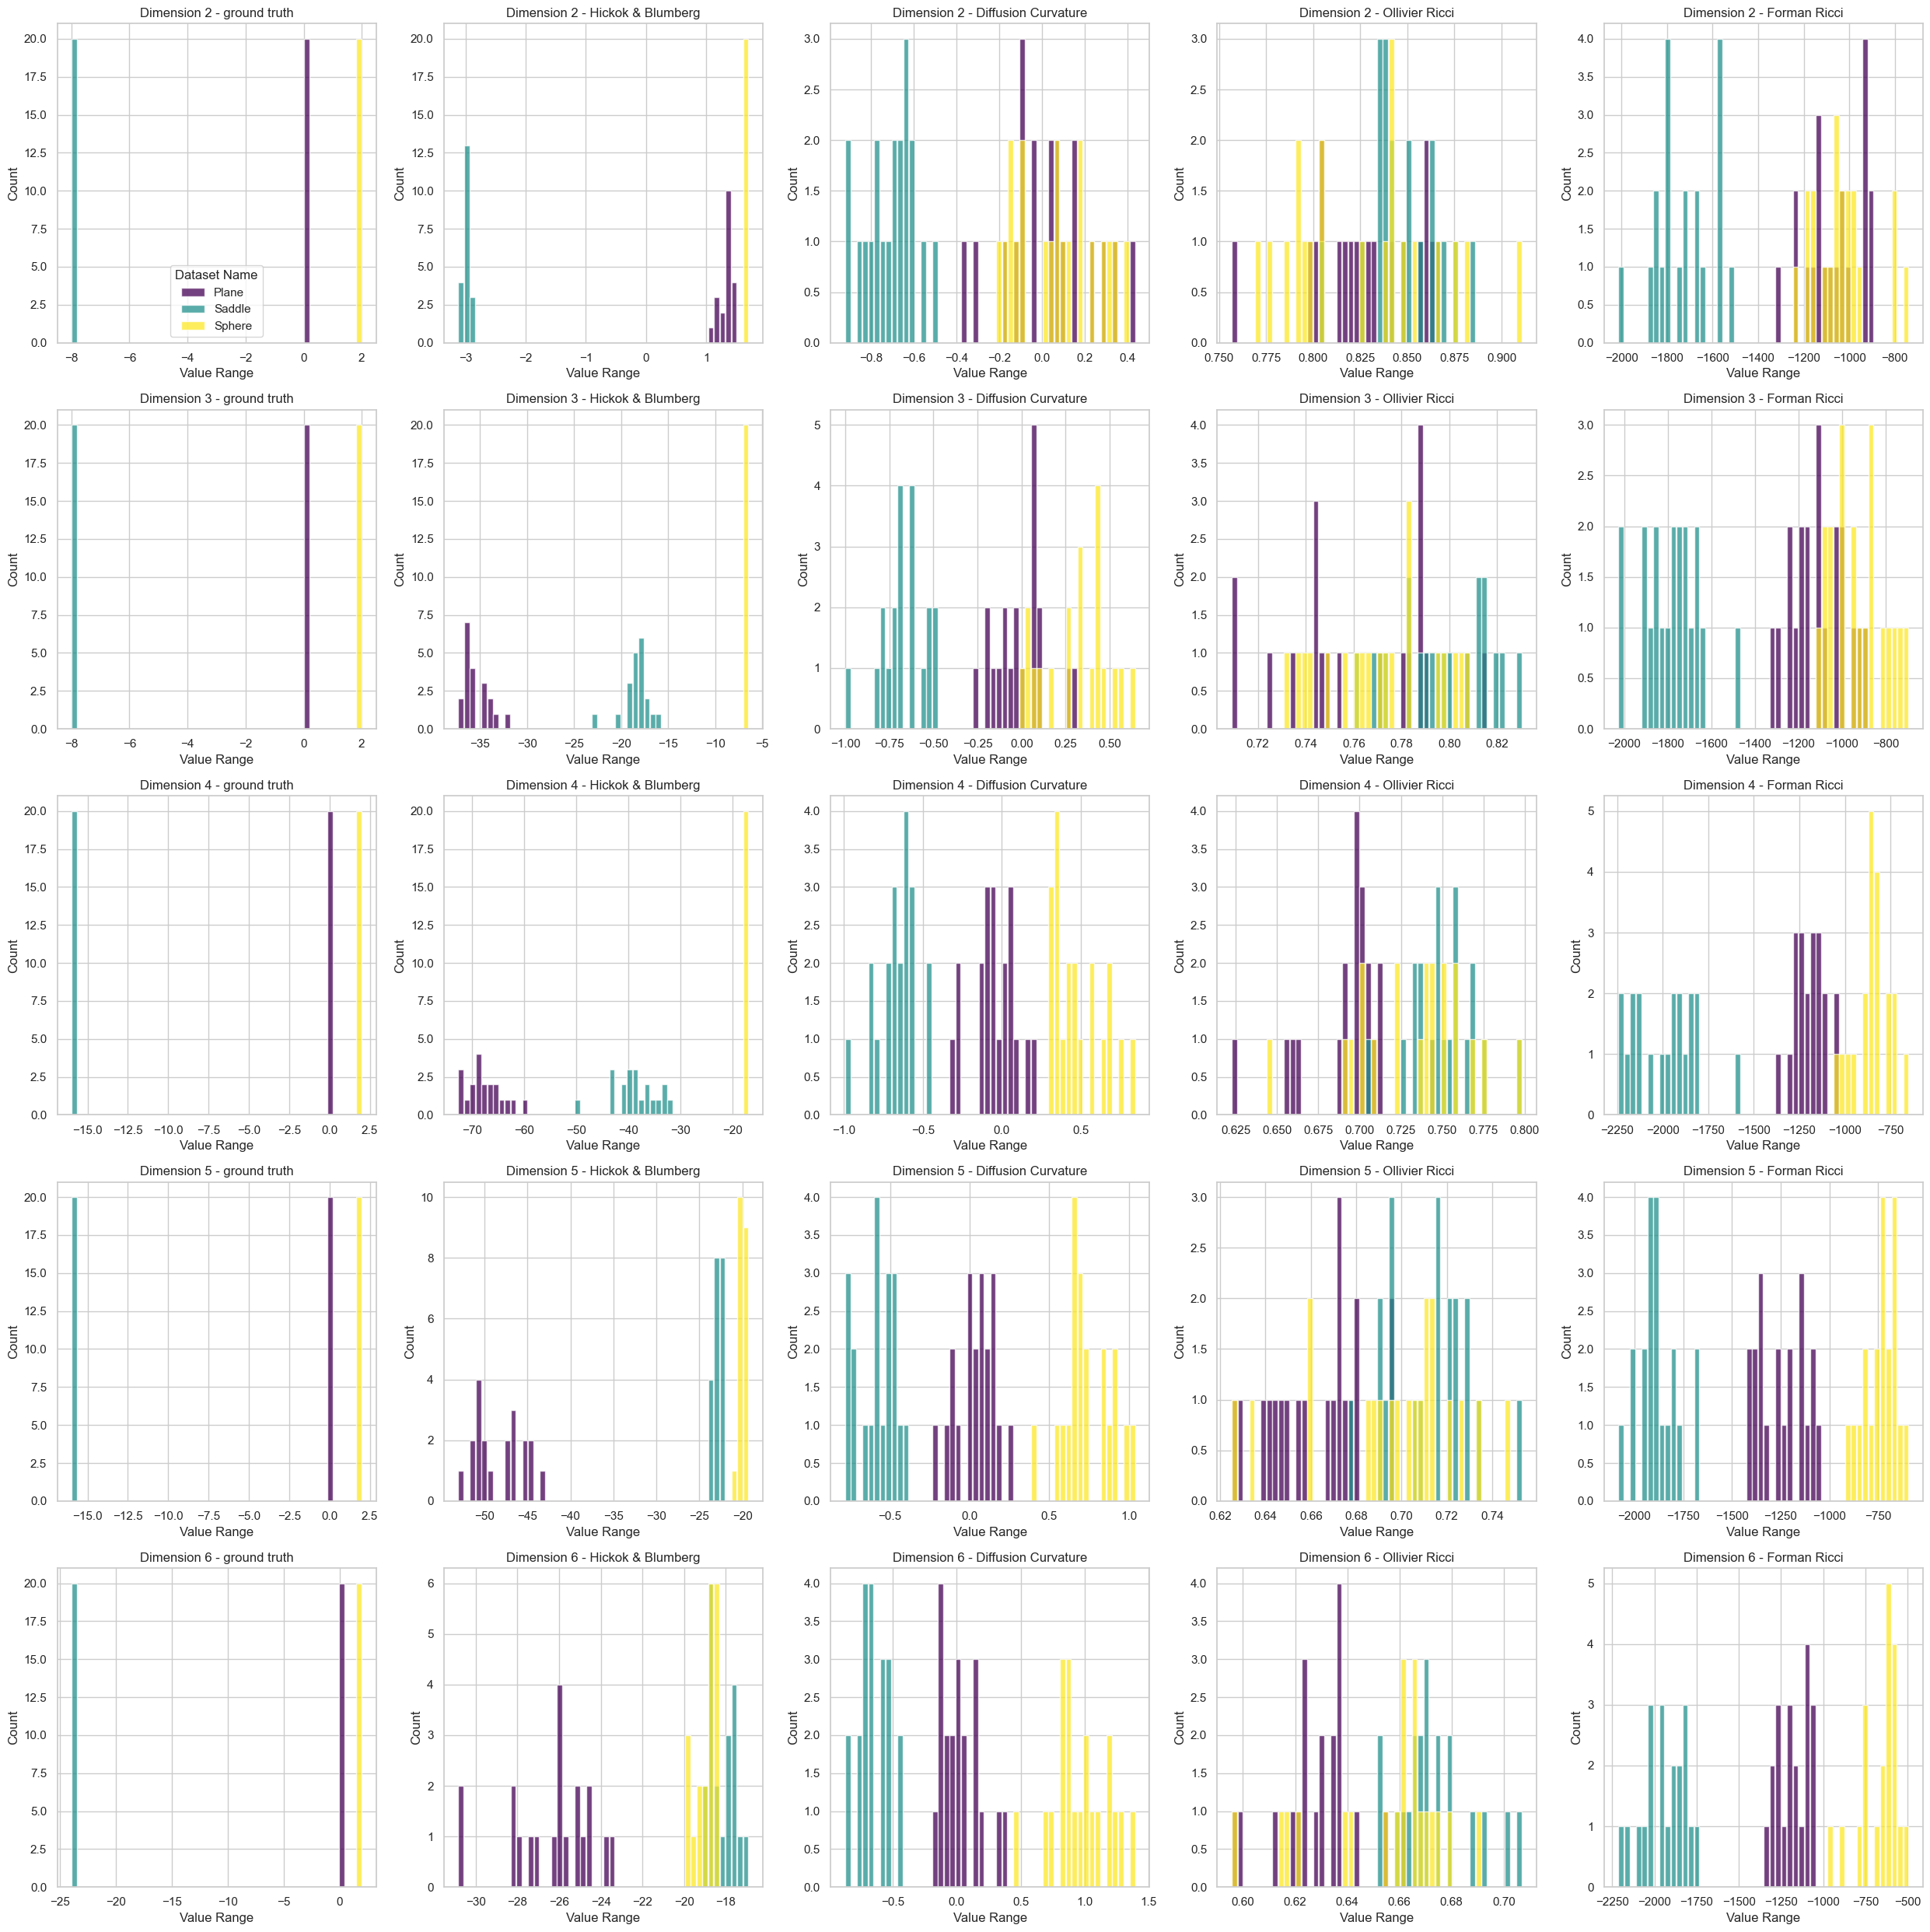

In [ ]:
SS1._aggregate_labels()
SS1.plot_by_dimension()

In [ ]:
dim = dims[1]
SS2 = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=False,
)
graph_former = partial(fixed_graph_former, alpha=1, sigma=0.2)
for X in tqdm(SS2):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
    )
    ks = DC.curvature(G, dim = dim, t = 25)
    SS2.update(ks[0], method_name="Diffusion Curvature")
    
    SC = scalar_curvature_est(
        n = dim, #manifold dim
        X = X, #data
        verbose=False,
    )
    ks_est = SC.estimate(rmax=2, indices=[0])
    SS2.update(ks_est[0], method_name="Hickok")
SS2.table()
SS_across_dims.append(SS2)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
dim = dims[2]
SS3 = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = num_pointclouds, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes=False,
)
graph_former = partial(fixed_graph_former, alpha=1, sigma=0.2)
for X in tqdm(SS3):
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Ollivier",
        graph_former = graph_former,
    )
    ks = DC.curvature(G, dim = dim, t = 25)
    SS3.update(ks[0], method_name="Diffusion Curvature")
    
    SC = scalar_curvature_est(
        n = dim, #manifold dim
        X = X, #data
        verbose=False,
    )
    ks_est = SC.estimate(rmax=2, indices=[0])
    SS3.update(ks_est[0], method_name="Hickok")
SS3.table()
SS_across_dims.append(SS3)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
SS1.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",0.693147
Diffusion Curvature,"(0.9984105720715597, 6.112610445808439e-24)",0.693147
Hickok,"(0.998019278582181, 4.4244318564697817e-23)",0.000000


In [ ]:
SS2.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",0.693147
Diffusion Curvature,"(0.996714712386192, 4.183748916786387e-21)",0.693147
Hickok,"(0.9821843344795909, 1.609923177144267e-14)",0.000000


In [ ]:
SS3.table()

,pearson_r,sign_score
ks,"(1.0, 0.0)",0.693147
Diffusion Curvature,"(0.9974141408831724, 4.863441066514706e-22)",0.693147
Hickok,"(0.719893584221904, 0.0003451575770241438)",0.000000


In [ ]:
SS_across_dims[-3].plot()

IndexError: list index out of range

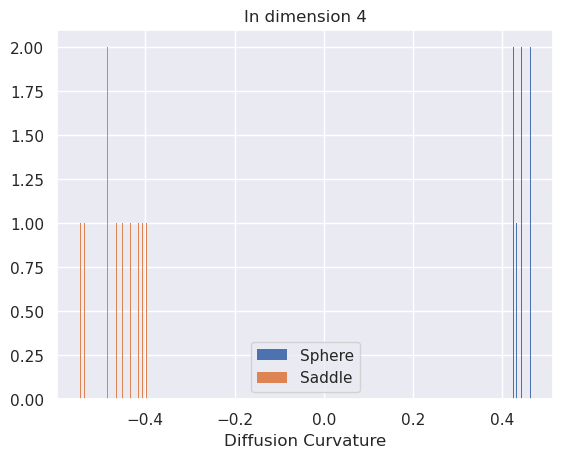

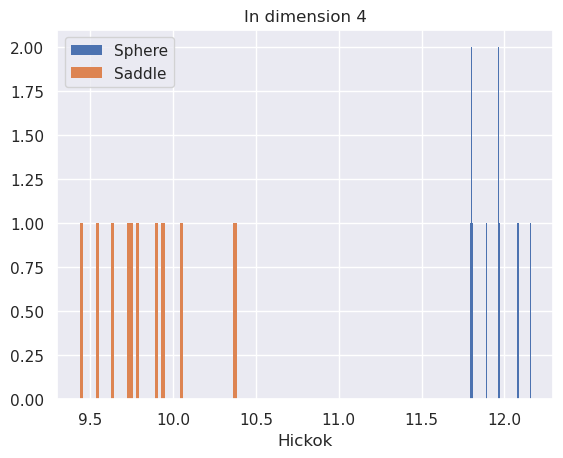

In [ ]:
SS2.plot()

In [ ]:
SS_across_dims[-3].plot()

IndexError: list index out of range

In [ ]:
len(SS)

20

# Results

We want to merge the dataframes of each dimension, and display them as a unified table.

In [ ]:
SSs = [SS1, SS2, SS3]

In [ ]:
import pandas as pd
dfs = [SS.table() for SS in SSs]
df = pd.concat(dfs)
# show nicely styled table
df.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background', '#606060'),
                ('color', 'white'),
                ('font-family', 'verdana')]},
     {'selector': 'td',
      'props': [('font-family', 'verdana')]},
     {'selector': 'tr:nth-of-type(odd)',
      'props': [('background', '#f9f9f9')]},
     {'selector': 'tr:nth-of-type(even)',
      'props': [('background', 'white')]},
     {'selector': 'tr:hover',
      'props': [('background-color', '#f4f4f4')]}
    ]
)


,pearson_r,sign_score
ks,"PearsonRResult(statistic=1.0, pvalue=0.0)",0.693147
Diffusion Curvature,"PearsonRResult(statistic=0.9984105720715597, pvalue=6.112610445808439e-24)",0.693147
Hickok,"PearsonRResult(statistic=0.998019278582181, pvalue=4.4244318564697817e-23)",0.000000
ks,"PearsonRResult(statistic=1.0, pvalue=0.0)",0.693147
Diffusion Curvature,"PearsonRResult(statistic=0.996714712386192, pvalue=4.183748916786387e-21)",0.693147
Hickok,"PearsonRResult(statistic=0.9821843344795909, pvalue=1.609923177144267e-14)",0.000000
ks,"PearsonRResult(statistic=1.0, pvalue=0.0)",0.693147
Diffusion Curvature,"PearsonRResult(statistic=0.9974141408831724, pvalue=4.863441066514706e-22)",0.693147
Hickok,"PearsonRResult(statistic=0.719893584221904, pvalue=0.0003451575770241438)",0.000000


In [ ]:
# plot a table of the above with rows and columns flipped
df.T.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background', '#606060'),
                ('color', 'white'),
                ('font-family', 'verdana')]},
     {'selector': 'td',
      'props': [('font-family', 'verdana')]},
     {'selector': 'tr:nth-of-type(odd)',
      'props': [('background', '#f9f9f9')]},
     {'selector': 'tr:nth-of-type(even)',
      'props': [('background', 'white')]},
     {'selector': 'tr:hover',
      'props': [('background-color', '#f4f4f4')]}
    ]
)

,ks,Diffusion Curvature,Hickok,ks,Diffusion Curvature,Hickok,ks,Diffusion Curvature,Hickok
pearson_r,"PearsonRResult(statistic=1.0, pvalue=0.0)","PearsonRResult(statistic=0.9984105720715597, pvalue=6.112610445808439e-24)","PearsonRResult(statistic=0.998019278582181, pvalue=4.4244318564697817e-23)","PearsonRResult(statistic=1.0, pvalue=0.0)","PearsonRResult(statistic=0.996714712386192, pvalue=4.183748916786387e-21)","PearsonRResult(statistic=0.9821843344795909, pvalue=1.609923177144267e-14)","PearsonRResult(statistic=1.0, pvalue=0.0)","PearsonRResult(statistic=0.9974141408831724, pvalue=4.863441066514706e-22)","PearsonRResult(statistic=0.719893584221904, pvalue=0.0003451575770241438)"
sign_score,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,0.000000


# Conclusion